In [ ]:
from google.colab import drive 
drive.mount("/gdrive")
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
ls

MyDrive/  Shareddrives/


In [ ]:
cd/gdrive/My Drive/Hotel-booking-analysis

/gdrive/My Drive/Hotel-booking-analysis


In [ ]:
ls

hotel_bookings.csv


## **INTRODUCTION**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
hotel_data = pd.read_csv('hotel_bookings.csv')

In [ ]:
hotel_data.head(10)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
6,Resort Hotel,0,0,2015,July,27,1,0,2,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,NaN,NaN,0,Transient,107.0,0,0,Check-Out,2015-07-03
7,Resort Hotel,0,9,2015,July,27,1,0,2,2,0.0,0,FB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,303.0,NaN,0,Transient,103.0,0,1,Check-Out,2015-07-03
8,Resort Hotel,1,85,2015,July,27,1,0,3,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,82.0,0,1,Canceled,2015-05-06
9,Resort Hotel,1,75,2015,July,27,1,0,3,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,15.0,NaN,0,Transient,105.5,0,0,Canceled,2015-04-22


In [ ]:
hotel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

## 1. Exploratory Data Analysis and Feature Engineering

In this part, I would like to visualize some features and show statistical relationship with target variable. This analysis will help to get overall view and deep familiarity of the data, detect extreme values and identify obvious errors. 

First graph is about exploring `hotel` feature which denotes type of the hotels. According to the below graph, approximately 34% of the data was booked for resort hotel and the rest of was booked for City Hotel. 

Text(0, 0.5, 'Count')

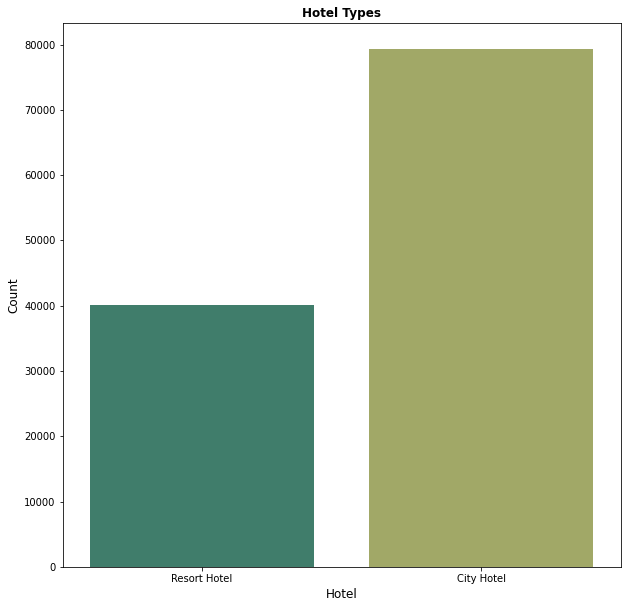

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(x='hotel', data = hotel_data, palette='gist_earth')
plt.title('Hotel Types', weight='bold')
plt.xlabel('Hotel', fontsize=12)
plt.ylabel('Count', fontsize=12)

Now, let's dive into the target value of data. The numbers are similar with hotel features. While 37% of booking canceled, 63% of booking is not canceled. These numbers also show that there is no balanced problem on the target value.  

Text(0, 0.5, 'Canceled or Not Canceled')

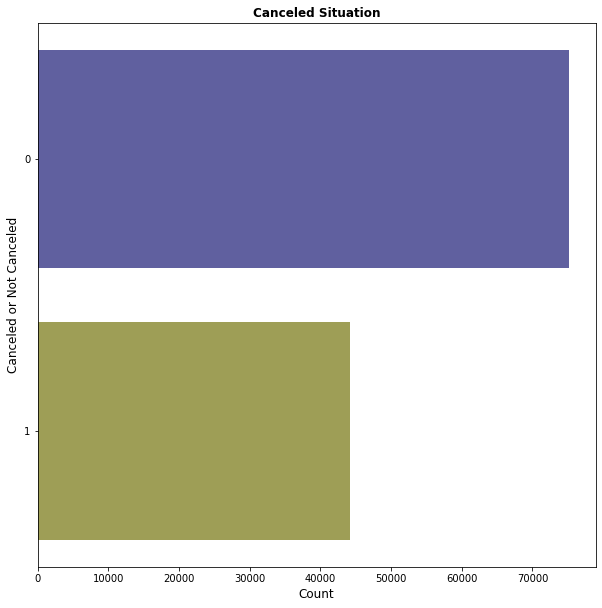

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(y='is_canceled', data= hotel_data, palette='gist_stern', orient = 'v')
plt.title('Canceled Situation', weight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Canceled or Not Canceled', fontsize=12)

Below graph shows the relationship of `arrival_date_year` to `lead_time` with booking cancellation status. The graph created by violin plot. Violin plot is a hybrid of box plot and density plot. It shows the distribution of the data. 

Three violin plots are correponding to three different years. For canceled booking, means and interquartile ranges are similar in all years. But the shapes of the distributions are quite different from each other. On the other hand distribution of not-canceled booking are almost the same. 
For all years and every booking situation, the small number of large lead time values are pulling the mean up. It shows that the mean is higher than the median. 

Text(0, 0.5, 'Lead Time')

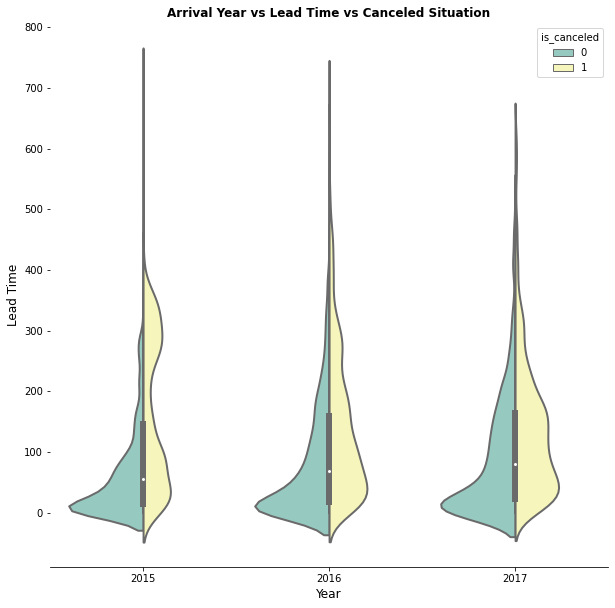

In [ ]:
plt.figure(figsize=(10,10))
sns.violinplot(x='arrival_date_year', y ='lead_time', hue="is_canceled", data=hotel_data, palette="Set3", bw=.2,
               cut=2, linewidth=2, iner= 'box', split = True)
sns.despine(left=True)
plt.title('Arrival Year vs Lead Time vs Canceled Situation', weight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Lead Time', fontsize=12)

Another exploration is made for the `arrival_date_month` feature. First month names converted to the numbers. It will help easier analysis. 

In [ ]:
hotel_data['arrival_date_month'].replace({'January' : '1',
        'February' : '2',
        'March' : '3',
        'April' : '4',
        'May' : '5',
        'June' : '6',
        'July' : '7',
        'August' : '8',
        'September' : '9', 
        'October' : '10',
        'November' : '11',
        'December' : '12'}, inplace=True)

Text(0, 0.5, 'Count')

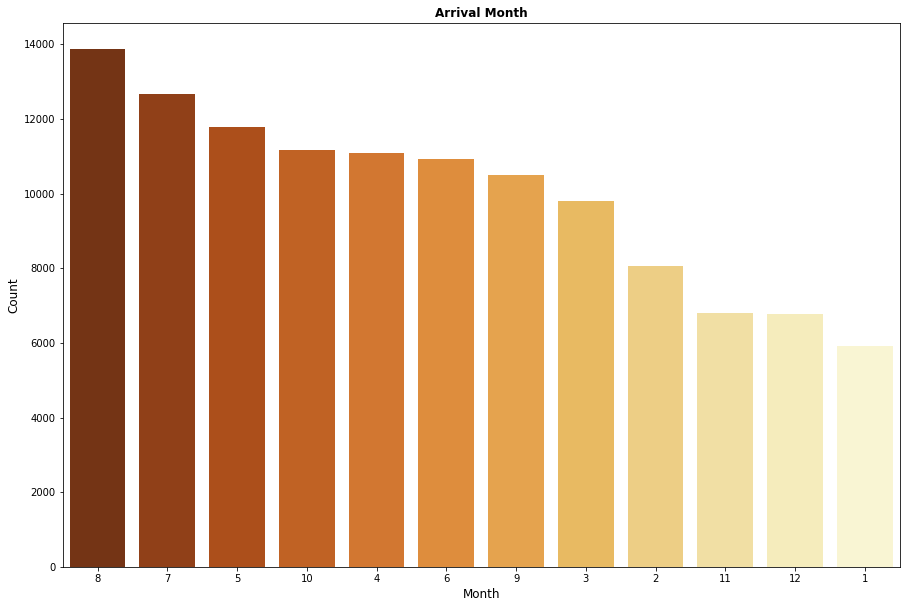

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(x='arrival_date_month', data = hotel_data,
              order=pd.value_counts(hotel_data['arrival_date_month']).index, palette='YlOrBr_r')
plt.title('Arrival Month', weight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Count', fontsize=12)

The above graph is showing the number of bookings for each month. According to that, August is the busiest month and January is the most unoccupied month. It is half as busy as August.

Another important features which are related to time are `stays_in_week_nights` and `stays_in_weekend_night` features. The below table shows the relationship between these two features. According to that, there is some missing data. 715 values are inputted zero both weekend and weeknights. However, this missing data is small enough to neglect. 

In [ ]:
pd.crosstab(index = hotel_data['stays_in_week_nights'],columns=hotel_data['stays_in_weekend_nights'], margins=True, margins_name = 'Total').iloc[:10]

stays_in_weekend_nights,0,1,2,3,4,5,6,7,8,9,10,12,13,14,16,18,19,Total
stays_in_week_nights,,,,,,,,,,,,,,,,,,
0,715,4569,2361,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7645
1,16451,7326,6533,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30310
2,17956,8979,6749,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33684
3,11564,6152,4542,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22258
4,4482,2412,2669,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9563
5,830,1188,8655,310,94,0,0,0,0,0,0,0,0,0,0,0,0,11077
6,0,0,851,301,347,0,0,0,0,0,0,0,0,0,0,0,0,1499
7,0,0,446,399,184,0,0,0,0,0,0,0,0,0,0,0,0,1029
8,0,0,393,131,132,0,0,0,0,0,0,0,0,0,0,0,0,656


The above table brings an idea about creating a new feature. Which is indicated `just_stay_weekend`, `just_stay_weekday` and `stay_both_weekday_and_weekday`. These 715 values which are not assigned any feature, indicated as undefined_data.

In [ ]:
pd.options.mode.chained_assignment = None
def week_function(feature1, feature2, data_source):
    data_source['weekend_or_weekday'] = 0
    for i in range(0, len(data_source)):
        if feature2.iloc[i] == 0 and feature1.iloc[i] > 0:
            hotel_data['weekend_or_weekday'].iloc[i] = 'stay_just_weekend'
        if feature2.iloc[i] > 0 and feature1.iloc[i] == 0:
            hotel_data['weekend_or_weekday'].iloc[i] = 'stay_just_weekday'
        if feature2.iloc[i] > 0 and feature1.iloc[i] > 0:
            hotel_data['weekend_or_weekday'].iloc[i] = 'stay_both_weekday_and_weekend'
        if feature2.iloc[i] == 0 and feature1.iloc[i] == 0:
            hotel_data['weekend_or_weekday'].iloc[i] = 'undefined_data'
            
week_function(hotel_data['stays_in_weekend_nights'],hotel_data['stays_in_week_nights'], hotel_data)

Next graph is about `weekend_or_weekday` feature's relationship with `arrival_date_month`. Below bar graph shows that most bookings were made to stay only for weekdays or both weekdays and weekends. On the other, numbers of staying just the weekend category are quite low compared to other categories. 

Text(0, 0.5, 'Count')

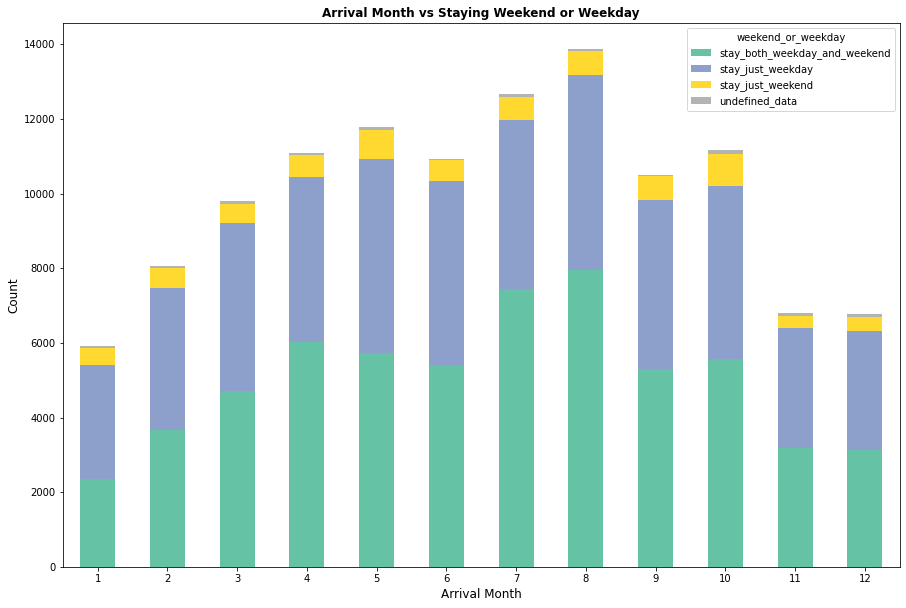

In [ ]:
hotel_data['arrival_date_month']= hotel_data['arrival_date_month'].astype('int64')
group_data = hotel_data.groupby([ 'arrival_date_month','weekend_or_weekday']).size().unstack(fill_value=0)
group_data.sort_values('arrival_date_month', ascending = True).plot(kind='bar',stacked=True, cmap='Set2',figsize=(15,10))
plt.title('Arrival Month vs Staying Weekend or Weekday', weight='bold')
plt.xlabel('Arrival Month', fontsize=12)
plt.xticks(rotation=360)
plt.ylabel('Count', fontsize=12)

Another feature engineering is made for `children` and `babies` features. Since, there is no obvious difference, these features gathered under the one feature which name is `all_children`.

In [ ]:
hotel_data['all_children'] = hotel_data['children'] + hotel_data['babies']
pd.crosstab(hotel_data['adults'], hotel_data['all_children'], margins=True, margins_name = 'Total').iloc[:10]

all_children,0.0,1.0,2.0,3.0,9.0,10.0,Total
adults,,,,,,,
0,180,4,205,14,0,0,403
1,22577,286,157,6,1,0,23027
2,81557,4658,3369,91,0,2,89677
3,5665,495,41,0,0,0,6201
4,59,3,0,0,0,0,62
5,2,0,0,0,0,0,2
6,1,0,0,0,0,0,1
10,1,0,0,0,0,0,1
20,2,0,0,0,0,0,2


Below the donut pie graph shows the meal categories. There is a big difference in the `Bed&Breakfast` category and the others. Almost 80% of bookings reserved for `Bed&Breakfast`. 

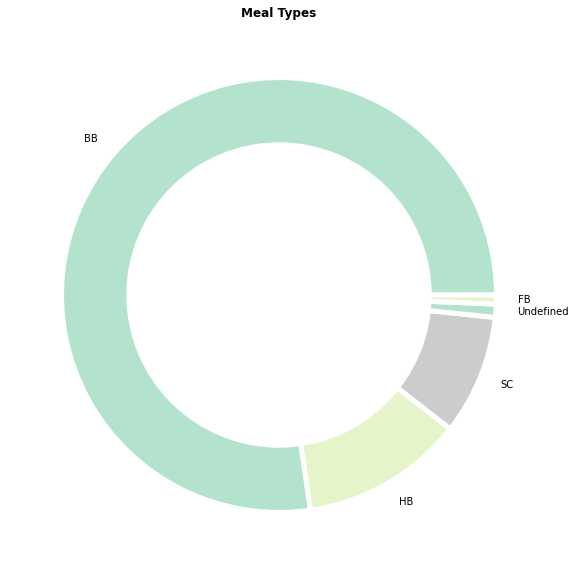

In [ ]:
meal_labels= ['BB','HB', 'SC', 'Undefined', 'FB']
size = hotel_data['meal'].value_counts()
plt.figure(figsize=(10,10))
cmap =plt.get_cmap("Pastel2")
colors = cmap(np.arange(3)*4)
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=meal_labels, colors=colors, wedgeprops = { 'linewidth' : 5, 'edgecolor' : 'white' })
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Meal Types', weight='bold')
plt.show()

The below table shows frequency details about meal types according to the hotel types. Following the results, 67% of `Bed&Breakfast` booking made for `City Hotel` and almost every `Full Board` bookings made in the `Resort Hotel`.

In [ ]:
group_meal_data = hotel_data.groupby(['hotel','meal']).size().unstack(fill_value=0).transform(lambda x: x/x.sum())
group_meal_data.applymap('{:.2f}'.format)

meal,BB,FB,HB,SC,Undefined
hotel,,,,,
City Hotel,0.67,0.06,0.44,0.99,0.00
Resort Hotel,0.33,0.94,0.56,0.01,1.00


The below graph gives information about the location which bookings made in. According to that, there is an apparent difference in booking location between Portugal and the others. Approx. 40% of all bookings made in the same location: Portugal. 

Text(0, 0.5, 'Count')

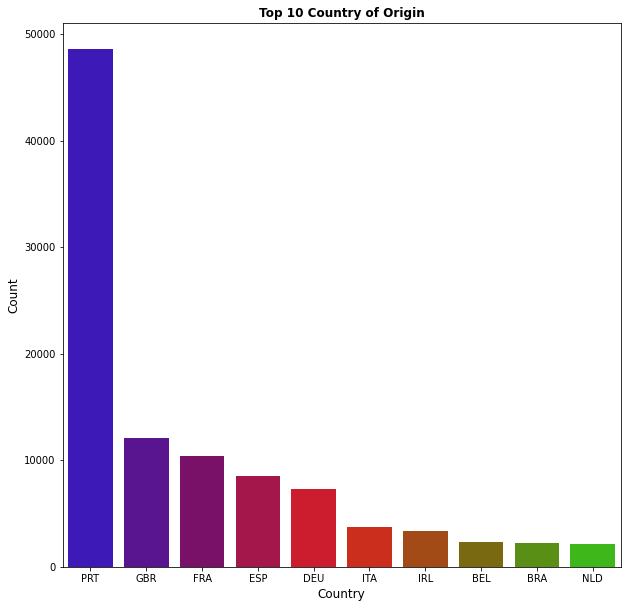

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(x='country', data=hotel_data, 
              order=pd.value_counts(hotel_data['country']).iloc[:10].index, palette="brg")
plt.title('Top 10 Country of Origin', weight='bold')
plt.xlabel('Country', fontsize=12)
plt.ylabel('Count', fontsize=12)

The statistics show that online hotel and airline reservations are increased in recent years. Most people complete their reservation via their smartphones. The below graphs is summarise these statistics. More than 45% of bookings are made via `Online Travel Agents` and around 20% of bookings made via `Offline Travel Agents`. Less than 20% of bookings made directly without any agents. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Count')

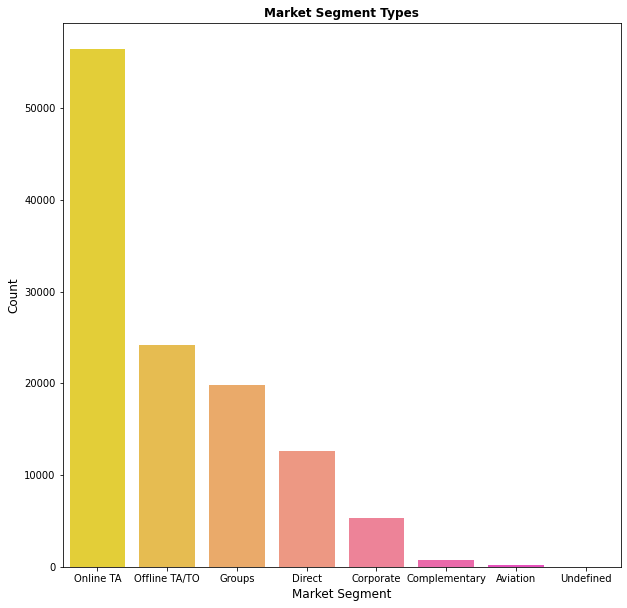

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(hotel_data['market_segment'], palette='spring_r', 
              order=pd.value_counts(hotel_data['market_segment']).index)
plt.title('Market Segment Types', weight='bold')
plt.xlabel('Market Segment', fontsize=12)
plt.ylabel('Count', fontsize=12)

Below crosstable shows if there is any difference between assigned and reserved room types or not. The results are shown as a percentage. Average 84% of bookings keep their reserved room and the rest of the' rooms have been changed. Every row represents the reserved type and distribution over the columns shows what was the assigned room despite of reserved type.

In [ ]:
pd.crosstab(index = hotel_data['reserved_room_type'], 
            columns = hotel_data['assigned_room_type'],normalize='index').round(2)*100

assigned_room_type,A,B,C,D,E,F,G,H,I,K,L,P
reserved_room_type,,,,,,,,,,,,
A,86.0,1.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B,10.0,88.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
C,1.0,0.0,95.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
D,2.0,0.0,0.0,92.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
E,0.0,0.0,0.0,0.0,91.0,6.0,2.0,0.0,1.0,0.0,0.0,0.0
F,0.0,1.0,0.0,0.0,1.0,93.0,4.0,0.0,0.0,0.0,0.0,0.0
G,0.0,0.0,0.0,0.0,0.0,1.0,97.0,0.0,1.0,0.0,0.0,0.0
H,0.0,0.0,0.0,0.0,0.0,0.0,2.0,97.0,1.0,0.0,0.0,0.0
L,17.0,17.0,17.0,0.0,0.0,17.0,0.0,17.0,0.0,0.0,17.0,0.0


Another exploratory analysis made for diving deep into the relationship between ADR and arrival month and booking cancellation status. As explained in the previous graph of `arrival month`, August is the most intense month of bookings. Besides the highest `Arrival Daily Rate` has ben occurred in that month too. Except for rush months like August, July, and September, canceled bookings have higher `ADR` than not canceled bookings. Maybe this highest rate could be one of the reasons for canceled bookings.

Text(0, 0.5, 'ADR')

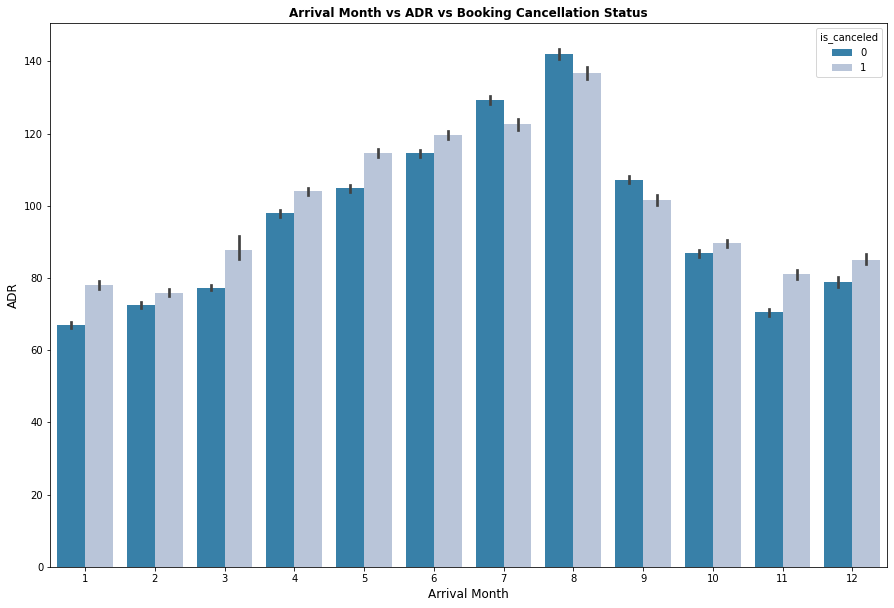

In [ ]:
hotel_data['adr'] = hotel_data['adr'].astype(float)
plt.figure(figsize=(15,10))
sns.barplot(x='arrival_date_month', y='adr', hue='is_canceled', dodge=True, palette= 'PuBu_r', data=hotel_data)
plt.title('Arrival Month vs ADR vs Booking Cancellation Status', weight='bold')
plt.xlabel('Arrival Month', fontsize=12)
plt.ylabel('ADR', fontsize=12)

The below graph is about `Total Special Request` numbers. Around 55% of bookings do not have any special requests. 

Text(0, 0.5, 'Count')

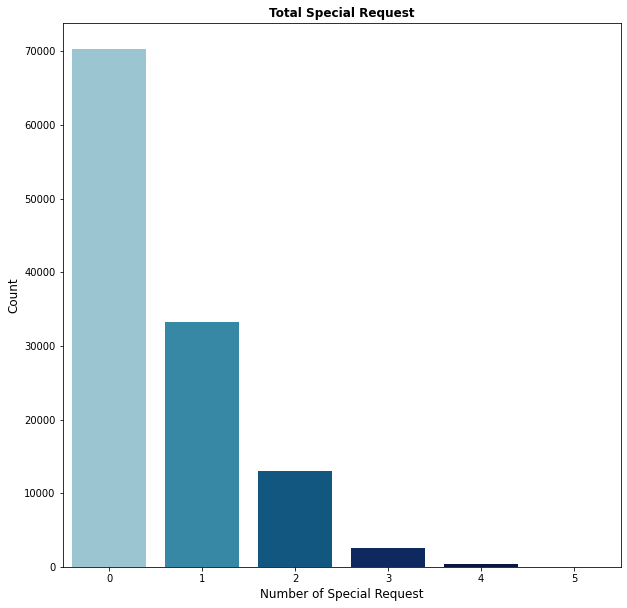

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(x='total_of_special_requests', data=hotel_data, palette = 'ocean_r')
plt.title('Total Special Request', weight='bold')
plt.xlabel('Number of Special Request', fontsize=12)
plt.ylabel('Count', fontsize=12)

The last graph is about the relationship between special requests and cancellation booking status. Nearly half bookings without any special requests have been canceled and another half of them have not been canceled. 

Text(0, 0.5, 'Count')

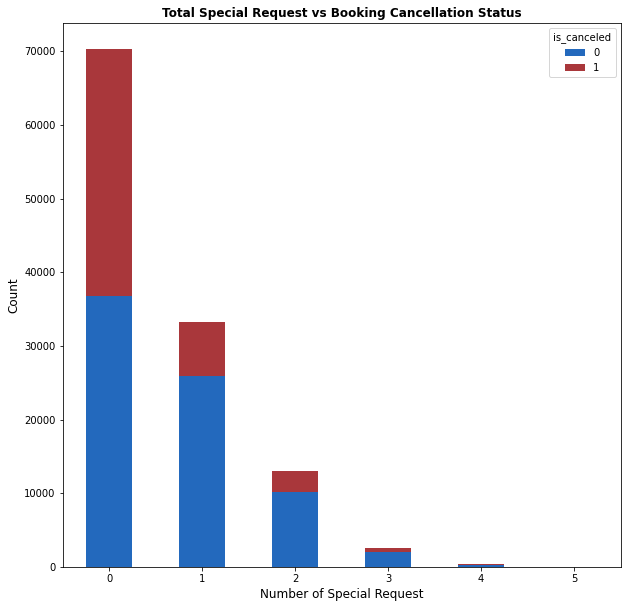

In [ ]:
group_adr_request = hotel_data.groupby([ 'total_of_special_requests', 'is_canceled']).size().unstack(fill_value=0)
group_adr_request.plot(kind='bar', stacked=True, cmap='vlag', figsize=(10,10))
plt.title('Total Special Request vs Booking Cancellation Status', weight='bold')
plt.xlabel('Number of Special Request', fontsize=12)
plt.xticks(rotation=360)
plt.ylabel('Count', fontsize=12)

## 2. Dealing with Missing Data and Correlation Matrix

In this part, first of all, any missing data will be checked.
The below code shows missing data for every feature. Such that, the `company` feature's 94% is missing. Because of that, this feature will be eliminated. On the other hand, the `children` and `all_children` features have only 4 missing data. This missing data will replace with zero. Another missing data has occurred in `country` and `agent` features. 
Since missing data of `country` is less than 1%, these data will replace with most frequent value. However, the `agent` missing features are more than the country. For this feature, missing data will be imputed as `0`. 

In [ ]:
hotel_data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [ ]:
hotel_data['children'] =  hotel_data['children'].fillna(0)
hotel_data['all_children'] =  hotel_data['all_children'].fillna(0)
hotel_data['country'] = hotel_data['country'].fillna(hotel_data['country'].mode().index[0])
hotel_data['agent']= hotel_data['agent'].fillna('0')
hotel_data=hotel_data.drop(['company'], axis =1)

In [ ]:
hotel_data['agent']= hotel_data['agent'].astype(int)
hotel_data['country']= hotel_data['country'].astype(str)

Another part is analyzing categorical features. Categorical labels converted into numerical form. This will help to be more understandable and implementable into machine learning algorithms. Some features are not ordinal such as `country`. In that case, *One-Hot Encoding* could be chosen. Due to the high number of categories, this method could incur higher computational cost. To help reducing that, Label Encoding method will be used.

In [ ]:
labelencoder = LabelEncoder()
hotel_data['hotel'] = labelencoder.fit_transform(hotel_data['hotel'])
hotel_data['arrival_date_month'] = labelencoder.fit_transform(hotel_data['arrival_date_month'])
hotel_data['meal'] = labelencoder.fit_transform(hotel_data['meal'])
hotel_data['country'] = labelencoder.fit_transform(hotel_data['country'])
hotel_data['market_segment']= labelencoder.fit_transform(hotel_data['market_segment'])
hotel_data['distribution_channel']=labelencoder.fit_transform(hotel_data['distribution_channel'])
hotel_data['is_repeated_guest'] = labelencoder.fit_transform(hotel_data['is_repeated_guest'])
hotel_data['reserved_room_type'] = labelencoder.fit_transform(hotel_data['reserved_room_type'])
hotel_data['assigned_room_type'] = labelencoder.fit_transform(hotel_data['assigned_room_type'])
hotel_data['deposit_type'] = labelencoder.fit_transform(hotel_data['deposit_type'])
hotel_data['agent'] = labelencoder.fit_transform(hotel_data['agent'])
hotel_data['customer_type'] = labelencoder.fit_transform(hotel_data['customer_type'])
hotel_data['reservation_status'] = labelencoder.fit_transform(hotel_data['reservation_status'])
hotel_data['weekend_or_weekday'] = labelencoder.fit_transform(hotel_data['weekend_or_weekday'])

After encoding the categorical data, two data frames will be created. One data frame has only categorical data and another has numerical data. These two different data frames will be used to create a correlation matrix. *Spearman* method will be used for categorical data correlation matrix and *Pearson* method will be used for numerical one. 

In [ ]:
hotel_data_categorical = hotel_data[['hotel','is_canceled','arrival_date_month','meal',
                                     'country','market_segment','distribution_channel', 
                                     'is_repeated_guest', 'reserved_room_type',
                                     'assigned_room_type','deposit_type','agent',
                                     'customer_type','reservation_status', 
                                     'weekend_or_weekday']]
hotel_data_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   hotel                 119390 non-null  int64
 1   is_canceled           119390 non-null  int64
 2   arrival_date_month    119390 non-null  int64
 3   meal                  119390 non-null  int64
 4   country               119390 non-null  int64
 5   market_segment        119390 non-null  int64
 6   distribution_channel  119390 non-null  int64
 7   is_repeated_guest     119390 non-null  int64
 8   reserved_room_type    119390 non-null  int64
 9   assigned_room_type    119390 non-null  int64
 10  deposit_type          119390 non-null  int64
 11  agent                 119390 non-null  int64
 12  customer_type         119390 non-null  int64
 13  reservation_status    119390 non-null  int64
 14  weekend_or_weekday    119390 non-null  int64
dtypes: int64(15)
memory usage: 13.7 MB

In [ ]:
hotel_data_numerical= hotel_data.drop(['hotel','is_canceled', 'arrival_date_month','meal',
                                       'country','market_segment','distribution_channel', 
                                       'is_repeated_guest', 'reserved_room_type', 
                                       'assigned_room_type','deposit_type','agent', 
                                       'customer_type','reservation_status',
                                       'weekend_or_weekday'], axis = 1)
hotel_data_numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   lead_time                       119390 non-null  int64  
 1   arrival_date_year               119390 non-null  int64  
 2   arrival_date_week_number        119390 non-null  int64  
 3   arrival_date_day_of_month       119390 non-null  int64  
 4   stays_in_weekend_nights         119390 non-null  int64  
 5   stays_in_week_nights            119390 non-null  int64  
 6   adults                          119390 non-null  int64  
 7   children                        119390 non-null  float64
 8   babies                          119390 non-null  int64  
 9   previous_cancellations          119390 non-null  int64  
 10  previous_bookings_not_canceled  119390 non-null  int64  
 11  booking_changes                 119390 non-null  int64  
 12  days_in_waiting_

Text(0.5, 1.0, 'Correlation Matrix Spearman Method- Categorical Data ')

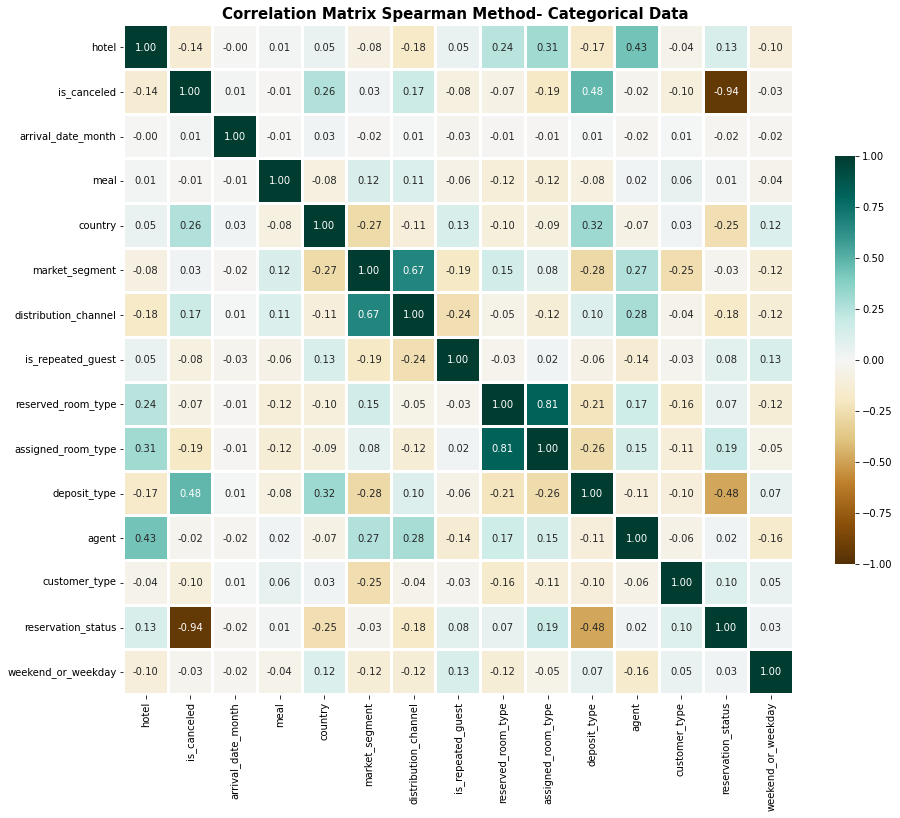

In [ ]:
plt.figure(figsize=(15,15))
corr_categorical=hotel_data_categorical.corr(method='spearman')
mask_categorical = np.triu(np.ones_like(corr_categorical, dtype=np.bool))
sns.heatmap(corr_categorical, annot=True, fmt=".2f", cmap='BrBG', vmin=-1, vmax=1, center= 0,
            square=True, linewidths=2, cbar_kws={"shrink": .5}).set(ylim=(15, 0))
plt.title("Correlation Matrix Spearman Method- Categorical Data ",size=15, weight='bold')

Text(0.5, 1.0, 'Correlation Matrix Pearson Method- Numerical Data ')

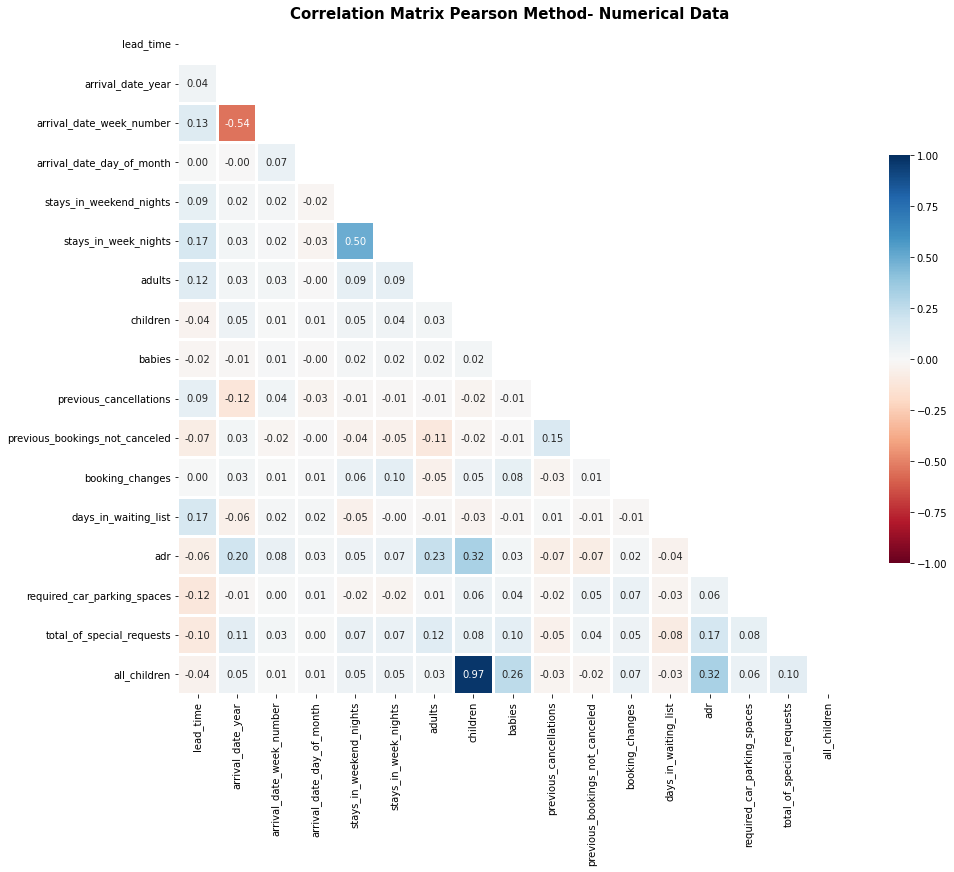

In [ ]:
plt.figure(figsize=(15,15))
corr_numerical=hotel_data_numerical.corr(method='pearson')
mask_numerical = np.triu(np.ones_like(corr_numerical, dtype=np.bool))
sns.heatmap(corr_numerical, annot=True, fmt=".2f", cmap='RdBu', mask= mask_numerical, vmin=-1, vmax=1, center= 0,
            square=True, linewidths=2, cbar_kws={"shrink": .5}).set(ylim=(17, 0))
plt.title("Correlation Matrix Pearson Method- Numerical Data ",size=15, weight='bold')

In [ ]:
corr_mask_categorical = corr_categorical.mask(mask_categorical)
corr_values_categorical = [c for c in corr_mask_categorical.columns if any (corr_mask_categorical[c] > 0.90)]
corr_mask_numerical = corr_numerical.mask(mask_numerical)
corr_values_numerical = [c for c in corr_mask_numerical.columns if any (corr_mask_numerical[c] > 0.90)]
print(corr_values_categorical, corr_values_numerical)

[] ['children']


The above correlation matrix shows positive or negative relationships between them. In those two heatmaps, the `reservation_ status` feature is drawn more attention because of its negative correlation with the `is_canceled` feature. The below table shows the relationship with details. This high correlation can cause a wrong prediction or overfitting. Prevent this situation, `reservation_status` feature will be eliminated. 

On the other hand, there is another high relationship between the `children` and the `all_children` features, since the `all_children` feature is constituted with the `children` and the `babies` features. Therefore the `children` feature will be eliminated too.

Last feature is `reservation_status_date`. Since this feature includes date type data and it could not convert another type, this feature will be eliminated. 

In [ ]:
# `reservation_status` vs `is_canceled` table

pd.crosstab(columns = hotel_data['reservation_status'], index = hotel_data['is_canceled'],
           margins=True, margins_name = 'Total')

reservation_status,0,1,2,Total
is_canceled,,,,
0,0,75166,0,75166
1,43017,0,1207,44224
Total,43017,75166,1207,119390


In [ ]:
hotel_data = hotel_data.drop(['reservation_status', 'children', 'reservation_status_date'], axis=1)

In [ ]:
hotel_data_model = hotel_data

## 3. Hyperparameter Tunning and Feature Importance

In this part, optimum hyperparameters for several tree-based machine learning algorithms will be searched with the help of the `Grid Search Algorithm`. Hyperparameter tuning will help to make a prediction in the training part more accurately. Therefore, hyperparameters tunning will be fixed before the training process. 

Another important work is constituted Permutation Feature Importance graph with the `Extreme Gradient Boosting` algorithm. This technique calculates feature importance and performance metric be chosen as the basis of the accuracy score. This graph will help to understand features' contributed to prediction, provide insight into the dataset, and will help to find deemed non-important features if any. 

In [ ]:
hotel_data_tunning = hotel_data
y = hotel_data_tunning.iloc[:,1]
X = pd.concat([hotel_data_tunning.iloc[:,0],hotel_data_tunning.iloc[:,2:30]], axis=1)

In [ ]:
#Finding parameters for XGBoost model
model = XGBClassifier()
parameters = {
'n_estimators' : [100,250,500],
'learning_rate' : [0.01, 0.1],
'subsample' :[0.5, 1.0],
'max_depth' : [3,5,7],
'criterion' : ['giny','entropy'],
'objective':['binary:logistic'],
}
grid_search = GridSearchCV(estimator=model, param_grid=parameters,
                           cv=5, scoring='f1', verbose=True, n_jobs=-1)
grid_search.fit(X, y)
print(grid_search.best_score_)
print(grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [ ]:
#Finding parameters for RF model
model_rfc_gs = RandomForestClassifier()
parameters_rfc = {
n_estimators' : [100,200,500],
'min_samples_split' : [2,4,6,8],
'min_samples_leaf': [1,2,4,6]
}
grid_search_rfc = GridSearchCV(estimator=model_rfc_gs, param_grid=parameters_rfc,
                           cv=5, scoring='f1', verbose=True, n_jobs=-1)
grid_search_rfc.fit(X, y)
grid_search_rfc.best_params_

In [ ]:
#Finding parameters for Extra Tree Classifier
model_etc_gs = ExtraTreesClassifier()
parameters_etc = {
'n_estimators' : [100,250,500],
'min_samples_split' : [2,4,6,8],
'min_samples_leaf': [1,3,5,7]
}
grid_search_etc = GridSearchCV(estimator=model_etc_gs, param_grid=parameters_etc,
                           cv=5, scoring='f1', verbose=True, n_jobs=-1)
grid_search_etc.fit(X, y)
grid_search_etc.best_params_

In [ ]:
#Finding parameters for Decision Tree
model_dtc_gs = DecisionTreeClassifier()
parameters_dtc = {
'criterion' : ['gini', 'entropy'],
'min_samples_split' : [2,4,6,8],
'min_samples_leaf': [1,2,3,4,5],
'max_features' : ['auto', 'sqrt']
}
grid_search_dtc = GridSearchCV(estimator=model_dtc_gs, param_grid=parameters_dtc,
                           cv=5, scoring='f1', verbose=True, n_jobs =-1)
grid_search_dtc.fit(X, y)
grid_search_dtc.best_params_

In [ ]:
params = {
    'criterion': 'giny', 
    'learning_rate': 0.01, 
    'max_depth': 5,
    'n_estimators': 100, 
    'objective': 'binary:logistic', 
}
model = XGBClassifier(parameters=params)
model.fit(X, y)
result = permutation_importance(model, X, y, scoring='accuracy', n_repeats = 5, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

In [ ]:
for i,v in enumerate(sorted_idx):
    print('Feature: %0d, Score: %.5f' % (i,v))

In [ ]:
fig, ax = plt.subplots(figsize=(20,15))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importance")
fig.tight_layout()
plt.show()

The above graph shows the feature importance of the features. according to that, 1 out of 29 features are not being important to prediction which is `babies`. It will eliminated.

In [ ]:
hotel_data_model = hotel_data_model.drop(['babies'], axis=1)

## 4. Model Building

In this part, some tree-based algorithms have been used for model building. These are *Decision Tree*, *Random Forest*, *Extra Trees Classifier*, and *Extreme Gradient Boosting*. *Random Forest* and *Extra Tree Classification* algorithms have been chosen as bagging algorithms, `XGBoost` has been chosen as one of the boosting algorithms. *Decision Tree* algorithm has been chosen as one tree algorithm. 

Before model building, data will be split to train and test respectively 70% and 30% ratio. 
`X_train` and `X_test` data will be standardized with the *Standard Scaler* technique. After that, the *Stratified K-Fold Cross Validation* method will be used for resampling. Cross-validation is an important implementation to avoid overfitting. *Stratified K-Fold Cross Validation* method provides train/test indices to split data into train/test sets.
Model parameters have been defined in the previous part. 

In [ ]:
y_model = hotel_data_model.iloc[:,1]
X_model = pd.concat([hotel_data_tunning.iloc[:,0],hotel_data_tunning.iloc[:,2:30]], axis=1)
y_model.describe()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.3, random_state=42, stratify = y)

In [ ]:
standardScalerX = StandardScaler()
X_train = standardScalerX.fit_transform(X_train)
X_test = standardScalerX.fit_transform(X_test)

In [ ]:
kfold_cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for train_index, test_index in kfold_cv.split(X_model,y_model):
    X_train, X_test = X_model.iloc[train_index], X_model.iloc[test_index]
    y_train, y_test = y_model.iloc[train_index], y_model.iloc[test_index]

In [ ]:
dtc_model = DecisionTreeClassifier(criterion= 'gini', min_samples_split=8,
                                  min_samples_leaf = 4, max_features = 'auto')
dtc_model.fit(X_train, y_train)
predict_dtc = dtc_model.predict(X_test)

In [ ]:
rf_model = RandomForestClassifier(min_samples_leaf = 6, min_samples_split=6,
                                  n_estimators = 100)
estimator= rf_model.fit(X_train, y_train)
predict_rf = rf_model.predict(X_test)

In [ ]:
etc_model = ExtraTreesClassifier(min_samples_leaf = 7, min_samples_split=2,
                                  n_estimators = 100)
etc_model.fit(X_train, y_train)
predict_etc = etc_model.predict(X_test)

In [ ]:
xgb_model = XGBClassifier(criterion = 'giny', learning_rate = 0.01, max_depth = 5, n_estimators = 100,
                          objective ='binary:logistic', subsample = 1.0)
xgb_model.fit(X_train, y_train)
predict_xgb = xgb_model.predict(X_test)

## 5. Classification Reports and Classification Matrix

The last part is comparison of classification reports of ML models. 


First comparison the accuracy results. 
* Accuracy is a ratio of correct predictions to the total predictions.  
Its formula is $(TP+TN) / (TP+FP+FN+TN)$

According to that, *Random Forest* have the highest correct prediction with 88%. 
Another performance metrics explained below:

* Precision: It is the ratio of correctly predicted observation to the total positive predicted observation. 
Its formula is $TP / (TP+FP)$
* Recall: It is the ratio of correctly predicted positive observations to the actual positive observations.
Its formula is $TP / (TP+FN)$

*Random Forest*  and the *Extra Tree Classifier* share the highest precision ratios. It means that both models predicted around 88% of all the positive labels correctly.  On the other hand *Random Forest* has the highest recall ratio. It means that this model predicted 79% of actual positive observations correctly.

In [ ]:
print("RF", classification_report(y_test, predict_rf))
print("DTC",classification_report(y_test, predict_dtc))
print("ETC", classification_report(y_test, predict_etc))
print("XGB", classification_report(y_test, predict_xgb))

In [ ]:
DTC_matrix = confusion_matrix(y_test, predict_dtc)
RF_matrix = confusion_matrix(y_test, predict_rf)
ETC_matrix = confusion_matrix(y_test, predict_etc)
XGB_matrix = confusion_matrix(y_test, predict_xgb) 
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.heatmap(RF_matrix,annot=True, fmt="d", cbar=False, cmap="Pastel2",  ax = ax[0]).set_ylim([0,2])
ax[0].set_title("Random Forest", weight='bold')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('Actual Labels')
sns.heatmap(DTC_matrix,annot=True, fmt="d" ,cbar=False, cmap="tab20", ax = ax[1]).set_ylim([0,2])
ax[1].set_title("Decision Tree", weight='bold')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('Actual Labels')
fig, axe = plt.subplots(1, 2, figsize=(15, 8))
sns.heatmap(ETC_matrix,annot=True, fmt="d", cbar=False, cmap="Paired", ax = axe[0]).set_ylim([0,2])
axe[0].set_title("Extra Tree Classifier", weight='bold')
axe[0].set_xlabel('Predicted Labels')
axe[0].set_ylabel('Actual Labels')
sns.heatmap(XGB_matrix,annot=True, fmt="d", cbar=False, cmap="Pastel1", ax = axe[1]).set_ylim([0,2])
axe[1].set_title("Gradient Boosting", weight='bold')
axe[1].set_xlabel('Predicted Labels')
axe[1].set_ylabel('Actual Labels')